In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['online-news-popularity-dataset']
/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv


# Linear and logistic model

In [2]:
df = pd.read_csv("../input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

This looks like exponential distribution.

(0.0, 15000.0)

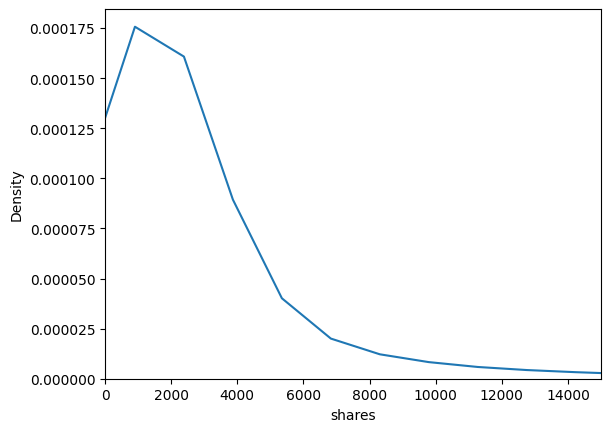

In [4]:
sns.kdeplot(df['shares'])
plt.xlim(0, 15000)

## Preprocessing

Lets drop columns `url`, because variable unique for all data set.  

In [5]:
df.drop(columns=['url'], axis=1, inplace=True)

Let also delete `kw_min_min` `kw_max_max` `n_non_stop_words` collumns, because all values same.

In [6]:
df['kw_max_max'].value_counts()

kw_max_max
843300    4951
663600       2
233400       1
Name: count, dtype: int64

In [7]:
df['kw_min_min'].value_counts()

kw_min_min
-1    4954
Name: count, dtype: int64

In [8]:
df['n_non_stop_words'].value_counts()

n_non_stop_words
1.0    1020
1.0     792
1.0     599
1.0     488
0.0     488
1.0     469
1.0     353
1.0     204
1.0     155
1.0     106
1.0      75
1.0      63
1.0      44
1.0      24
1.0      23
1.0      13
1.0       8
1.0       8
1.0       4
1.0       3
1.0       3
1.0       2
1.0       2
1.0       2
1.0       2
1.0       2
1.0       1
1.0       1
Name: count, dtype: int64

In [9]:
garbage = ['kw_max_max', 'kw_min_min', 'n_non_stop_words']
df.drop(columns=garbage, axis=1, inplace=True)

Lets delete anomaly articles that have shares>=15000 and <400 and log our target variable to make distribution more familiar to normal.

In [10]:
df['shares'].value_counts()

shares
1100     316
1200     279
1300     225
1400     224
1500     165
        ... 
26900      1
569        1
19100      1
477        1
470        1
Name: count, Length: 781, dtype: int64

In [11]:
df = df[df['shares'] <= 15000]
df = df[df['shares'] > 200]

<Axes: xlabel='shares', ylabel='Density'>

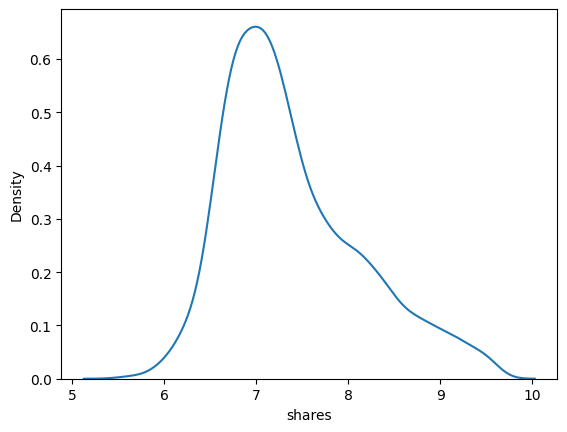

In [12]:
y_regretion = np.log(df['shares'])
sns.kdeplot(y_regretion)

Like previous model, lets also see classification issues.

In [13]:
df['is_popular'] = (df['shares'] > 1500).astype(int)
df.drop(columns=['shares'], axis=1, inplace=True)
df['is_popular'].value_counts()

is_popular
0    2741
1    2041
Name: count, dtype: int64

## Split Data

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop('is_popular', axis=1)
y_classification = df['is_popular']
X_train, X_valid, y_train_cl, y_valid_cl = train_test_split(X, y_classification, test_size=0.25, random_state=4)
X_train, X_valid, y_train_reg, y_valid_reg = train_test_split(X, y_regretion, test_size=0.25, random_state=4)

## Classifier and Regressor

Lets build Liear Regression and Logistic Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix

In [16]:
linear_regression = LinearRegression()
logistic_regression = LogisticRegression(random_state=20)

In [17]:
linear_regression.fit(X_train, y_train_reg)

LinearRegression()

In [18]:
logistic_regression.fit(X_train, y_train_cl)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=20)

We have good result even without searching hyperparameters

In [19]:
y_pred = linear_regression.predict(X_valid)

print('MSE:', mean_squared_error(y_valid_reg, y_pred))
print('R2:', r2_score(y_valid_reg, y_pred))

MSE: 0.4634111299609709
R2: 0.15669649376423256


In [20]:
y_pred = logistic_regression.predict(X_valid)

print('accuracy:', accuracy_score(y_valid_cl, y_pred))
print('precision_score:', precision_score(y_valid_cl, y_pred))
print('recall_score:', recall_score(y_valid_cl, y_pred))
print('f1_score:', f1_score(y_valid_cl, y_pred))

accuracy: 0.6011705685618729
precision_score: 0.5408805031446541
recall_score: 0.341948310139165
f1_score: 0.4190012180267966


In [21]:
print(confusion_matrix(y_valid_cl, y_pred))

[[547 146]
 [331 172]]


Lets build confusion matrix to see what result we have. And what metric we want to take.

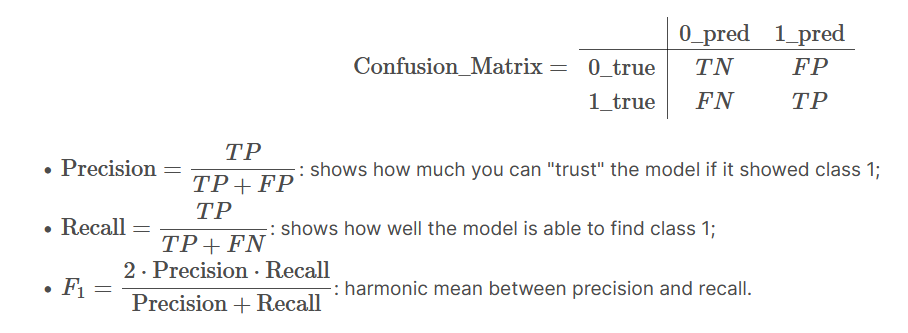

* TN --- True Negative --- the number of class 0 objects that the model recognized correctly;
* TP --- True Positive --- the number of class 1 objects that the model recognized correctly;
* FP --- False Positive --- the number class 0 objects that the model incorrectly assigned to class 1;
* FN --- False Negative --- the number class 1 objects that the model incorrectly assigned to class 0.

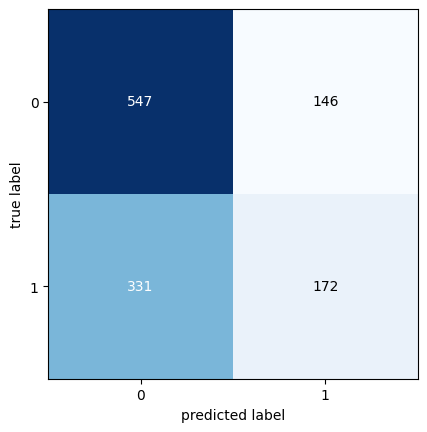

In [22]:
plot_confusion_matrix(confusion_matrix(y_valid_cl, y_pred))
plt.show()

Lets take f1 for minimaze FN and FP, because it is bad for this model, when we have a lot popular articles that are not popular, and when we have popular articles that model see like not popular.

Lets see our parameters in regressions. `LDA_02`, `LDA_03`, `LDA_04` have big coef, because have small values.

In [23]:
feature_names = X_train.columns
coefficients = np.round(linear_regression.coef_, 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

LDA_02: -9388889.1459
LDA_03: -9388889.0829
LDA_04: -9388889.0159
LDA_00: -9388888.9304
LDA_01: -9388888.8959
weekday_is_monday: 102.5569
weekday_is_thursday: 102.5126
weekday_is_friday: 102.5068
weekday_is_tuesday: 102.491
weekday_is_wednesday: 102.4322
is_weekend: 99.0284
weekday_is_sunday: 3.7767
weekday_is_saturday: 3.7588
global_rate_negative_words: -1.5856
global_rate_positive_words: 1.442
global_sentiment_polarity: -0.9621
n_non_stop_unique_tokens: -0.6618
rate_positive_words: 0.6477
n_unique_tokens: 0.6254
avg_positive_polarity: 0.3674
rate_negative_words: 0.2744
data_channel_is_entertainment: -0.2153
min_positive_polarity: -0.1826
data_channel_is_lifestyle: -0.139
data_channel_is_socmed: 0.1312
data_channel_is_tech: 0.1235
average_token_length: -0.1127
max_positive_polarity: 0.1126
data_channel_is_world: -0.058
avg_negative_polarity: 0.0557
global_subjectivity: 0.0508
title_subjectivity: 0.0361
max_negative_polarity: 0.0305
num_keywords: 0.028
abs_title_subjectivity: 0.0257
da

For logistic model we have that model retrained

In [24]:
feature_names = X_train.columns
coefficients = np.round(logistic_regression.coef_[0], 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

n_tokens_content: -0.0003
kw_avg_avg: 0.0003
kw_max_avg: -0.0001
timedelta: 0.0
n_tokens_title: -0.0
n_unique_tokens: -0.0
n_non_stop_unique_tokens: -0.0
num_hrefs: 0.0
num_self_hrefs: -0.0
num_imgs: 0.0
num_videos: -0.0
average_token_length: -0.0
num_keywords: -0.0
data_channel_is_lifestyle: 0.0
data_channel_is_entertainment: -0.0
data_channel_is_bus: 0.0
data_channel_is_socmed: 0.0
data_channel_is_tech: 0.0
data_channel_is_world: -0.0
kw_max_min: -0.0
kw_avg_min: -0.0
kw_min_max: 0.0
kw_avg_max: -0.0
kw_min_avg: 0.0
self_reference_min_shares: -0.0
self_reference_max_shares: -0.0
self_reference_avg_sharess: 0.0
weekday_is_monday: -0.0
weekday_is_tuesday: -0.0
weekday_is_wednesday: -0.0
weekday_is_thursday: -0.0
weekday_is_friday: -0.0
weekday_is_saturday: 0.0
weekday_is_sunday: 0.0
is_weekend: 0.0
LDA_00: 0.0
LDA_01: -0.0
LDA_02: -0.0
LDA_03: 0.0
LDA_04: 0.0
global_subjectivity: -0.0
global_sentiment_polarity: 0.0
global_rate_positive_words: -0.0
global_rate_negative_words: -0.0
rate_

Lets standart our data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler_reg = StandardScaler()
scaler_reg.fit(X_train, y_train_reg)

X_train_st_reg = scaler_reg.transform(X_train)
X_valid_st_reg = scaler_reg.transform(X_valid)

In [27]:
scaler_cl = StandardScaler()
scaler_cl.fit(X_train, y_train_cl)

X_train_st_cl = scaler_cl.transform(X_train)
X_valid_st_cl = scaler_cl.transform(X_valid)

And now lets see what result we have

In [28]:
linear_regression.fit(X_train_st_reg, y_train_reg)

LinearRegression()

In [29]:
logistic_regression.fit(X_train_st_cl, y_train_cl)

LogisticRegression(random_state=20)

We have the same result for linear regression

In [30]:
y_pred = linear_regression.predict(X_valid_st_reg)

print('MSE:', mean_squared_error(y_valid_reg, y_pred))
print('R2:', r2_score(y_valid_reg, y_pred))

MSE: 0.4635265680349607
R2: 0.15648642256340295


And more better for logistic regression

In [31]:
y_pred = logistic_regression.predict(X_valid_st_cl)

print('accuracy:', accuracy_score(y_valid_cl, y_pred))
print('precision_score:', precision_score(y_valid_cl, y_pred))
print('recall_score:', recall_score(y_valid_cl, y_pred))
print('f1_score:', f1_score(y_valid_cl, y_pred))

accuracy: 0.6847826086956522
precision_score: 0.6418918918918919
recall_score: 0.5666003976143141
f1_score: 0.6019007391763463


And now we have coef standart coef, but for classification is small

In [32]:
feature_names = X_train.columns
coefficients = np.round(linear_regression.coef_, 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

weekday_is_tuesday: -114236159644.803
weekday_is_wednesday: -108645943123.055
weekday_is_monday: -107843217094.6214
weekday_is_thursday: -105701886526.8734
weekday_is_friday: -100163637223.1112
is_weekend: -86984787732.1272
weekday_is_sunday: -6164231679.1376
weekday_is_saturday: -5698160040.0819
LDA_02: -2938818.6479
LDA_03: -2929206.8624
LDA_04: -2463353.0699
LDA_00: -2236716.9342
LDA_01: -2055222.1009
kw_avg_avg: 0.3057
kw_max_avg: -0.1706
rate_positive_words: 0.1622
average_token_length: -0.1615
n_non_stop_unique_tokens: -0.1486
self_reference_avg_sharess: 0.1293
n_unique_tokens: 0.1161
timedelta: 0.1074
global_sentiment_polarity: -0.0915
data_channel_is_entertainment: -0.0831
self_reference_min_shares: -0.0788
num_keywords: 0.0517
avg_positive_polarity: 0.0516
rate_negative_words: 0.0497
kw_avg_min: 0.047
self_reference_max_shares: -0.0455
kw_min_avg: -0.042
data_channel_is_tech: 0.0404
kw_max_min: -0.0381
num_hrefs: 0.038
num_videos: -0.0348
max_positive_polarity: 0.0323
num_imgs

In [33]:
feature_names = X_train.columns
coefficients = np.round(logistic_regression.coef_[0], 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

kw_avg_avg: 0.6909
average_token_length: -0.5212
rate_positive_words: 0.4651
kw_max_avg: -0.4303
n_non_stop_unique_tokens: -0.4042
self_reference_avg_sharess: 0.3532
n_unique_tokens: 0.3417
self_reference_min_shares: -0.2527
timedelta: 0.2347
kw_avg_min: 0.2192
kw_max_min: -0.2142
global_sentiment_polarity: -0.1932
data_channel_is_entertainment: -0.1872
num_keywords: 0.1733
avg_positive_polarity: 0.1576
is_weekend: 0.1368
num_imgs: 0.1209
title_subjectivity: 0.116
data_channel_is_tech: 0.1151
num_hrefs: 0.1071
min_negative_polarity: -0.1051
LDA_02: -0.1012
avg_negative_polarity: 0.0999
weekday_is_wednesday: -0.0973
weekday_is_saturday: 0.096
rate_negative_words: 0.0955
data_channel_is_world: -0.0923
weekday_is_sunday: 0.0911
num_videos: -0.0897
data_channel_is_socmed: 0.0876
n_tokens_content: 0.0846
num_self_hrefs: -0.0814
LDA_00: 0.079
abs_title_sentiment_polarity: -0.0712
data_channel_is_lifestyle: -0.0706
global_subjectivity: 0.0687
global_rate_negative_words: -0.0626
title_sentimen

## Ridge, Lasso, ElasticNet

In [34]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import GridSearchCV

In [35]:
ridge = Ridge()
lasso = Lasso(max_iter=5000, random_state=20)
EN = ElasticNet(max_iter=5000, random_state=20)
l1 = LogisticRegression(solver='liblinear', penalty='l1', random_state=20)
l2 = LogisticRegression(solver='liblinear', penalty='l2', random_state=20)
en_cl = LogisticRegression(solver='saga', penalty='elasticnet', random_state=20)
params = {
    'alpha': np.logspace(-4, 4, 9),
    'l1_ratio': np.linspace(0, 1, 5),
}

ridge_grid_reg = GridSearchCV(ridge, {'alpha': params['alpha']}, cv=5, scoring='r2')
lasso_grid_reg = GridSearchCV(lasso, {'alpha': params['alpha']}, cv=5, scoring='r2')
EN_grid_reg = GridSearchCV(EN, params, cv=5, scoring='r2')

ridge_grid_cl = GridSearchCV(l2, {'C': params['alpha']}, cv=5, scoring='f1')
lasso_grid_cl = GridSearchCV(l1, {'C': params['alpha']}, cv=5, scoring='f1')
EN_grid_cl = GridSearchCV(en_cl, {'C': params['alpha'], 'l1_ratio': params['l1_ratio']}, cv=5, scoring='f1')

### Ridge

In [36]:
ridge_grid_reg.fit(X_train_st_reg, y_train_reg)
ridge_grid_cl.fit(X_train_st_cl, y_train_cl)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=20, solver='liblinear'),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             scoring='f1')

In [37]:
print("Best params for classification:", ridge_grid_cl.best_params_)
print("Best score for classification:", ridge_grid_cl.best_score_)
print("Best params for regressor:", ridge_grid_reg.best_params_)
print("Best neg mean score for regressor:", ridge_grid_reg.best_score_)

Best params for classification: {'C': 0.0001}
Best score for classification: 0.5965786019172739
Best params for regressor: {'alpha': 10.0}
Best neg mean score for regressor: 0.1520824161417373


### Lasso

In [38]:
lasso_grid_reg.fit(X_train_st_reg, y_train_reg)
lasso_grid_cl.fit(X_train_st_cl, y_train_cl)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=20,
                                          solver='liblinear'),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             scoring='f1')

In [39]:
print("Best params for classification:", lasso_grid_cl.best_params_)
print("Best score for classification:", lasso_grid_cl.best_score_)
print("Best params for regressor:", lasso_grid_reg.best_params_)
print("Best neg mean score for regressor:", lasso_grid_reg.best_score_)

Best params for classification: {'C': 0.1}
Best score for classification: 0.5628351958174297
Best params for regressor: {'alpha': 0.001}
Best neg mean score for regressor: 0.15265752345765055


### ElasticNet

In [40]:
EN_grid_reg.fit(X_train_st_reg, y_train_reg)
EN_grid_cl.fit(X_train_st_cl, y_train_cl)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.536e+02, tolerance: 1.628e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.502e+02, tolerance: 1.589e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='elasticnet', random_state=20,
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             scoring='f1')

In [41]:
print("Best params for classification:", EN_grid_cl.best_params_)
print("Best score for classification:", EN_grid_cl.best_score_)
print("Best params for regressor:", EN_grid_reg.best_params_)
print("Best neg mean score for regressor:", EN_grid_reg.best_score_)

Best params for classification: {'C': 1.0, 'l1_ratio': 0.25}
Best score for classification: 0.5608159235727695
Best params for regressor: {'alpha': 0.001, 'l1_ratio': 0.75}
Best neg mean score for regressor: 0.1526838488377385


We have same that for linear regularisation we have weak regularisation, for logistic strong

We also have almost same result for 3 models, but for linear regularisation we have the best result on EN, and for logistic l2

<BarContainer object of 3 artists>

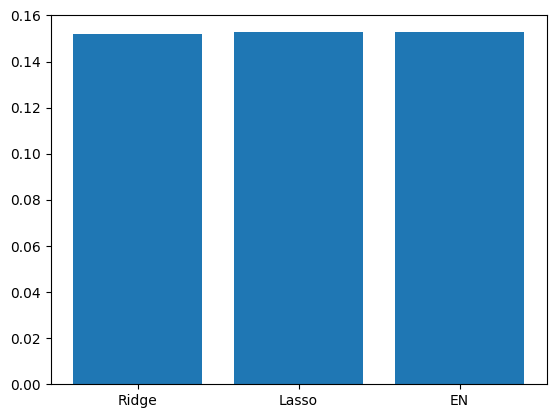

In [42]:
plt.bar(['Ridge', 'Lasso', 'EN'], [ridge_grid_reg.best_score_, lasso_grid_reg.best_score_, EN_grid_reg.best_score_])

<BarContainer object of 3 artists>

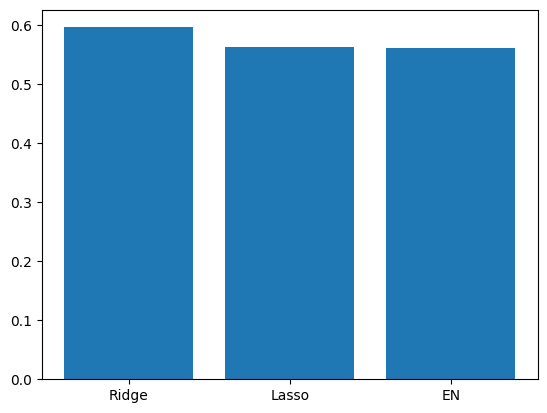

In [43]:
plt.bar(['Ridge', 'Lasso', 'EN'], [ridge_grid_cl.best_score_, lasso_grid_cl.best_score_, EN_grid_cl.best_score_])

Lets see what happening with validation curve

In [44]:
from sklearn.model_selection import validation_curve

We can see that we have the same graphics

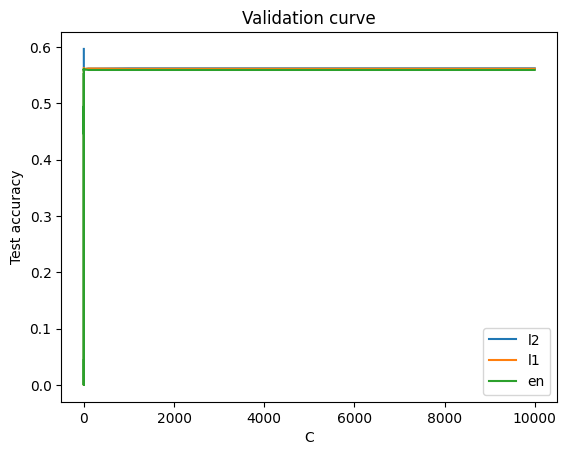

In [45]:
results_l2 = pd.DataFrame(ridge_grid_cl.cv_results_)
results_l1 = pd.DataFrame(lasso_grid_cl.cv_results_)
results_en = pd.DataFrame(EN_grid_cl.cv_results_)
plt.plot(results_l2['param_C'], results_l2['mean_test_score'])
plt.plot(results_l1['param_C'], results_l1['mean_test_score'])
plt.plot(results_en['param_C'], results_en['mean_test_score'])
plt.legend (('l2', 'l1', 'en'))

plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

## Coefficients 

In [46]:
EN_reg_best = EN_grid_reg.best_estimator_
y_pred = EN_reg_best.predict(X_valid_st_reg)
print("r2:", r2_score(y_valid_reg, y_pred))

r2: 0.1582358763409888


In [47]:
feature_names = X_train.columns
coefficients = np.round(EN_reg_best.coef_, 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

kw_avg_avg: 0.291
kw_max_avg: -0.1597
timedelta: 0.1073
self_reference_avg_sharess: 0.0998
is_weekend: 0.0952
rate_positive_words: 0.0935
average_token_length: -0.0847
data_channel_is_entertainment: -0.0808
global_sentiment_polarity: -0.072
n_non_stop_unique_tokens: -0.0615
self_reference_min_shares: -0.0607
num_keywords: 0.0513
data_channel_is_tech: 0.0459
LDA_02: -0.0426
num_hrefs: 0.0386
num_videos: -0.036
kw_min_avg: -0.035
n_unique_tokens: 0.034
num_imgs: 0.0331
avg_positive_polarity: 0.0331
max_positive_polarity: 0.0314
self_reference_max_shares: -0.0283
weekday_is_wednesday: -0.0278
LDA_01: 0.0272
kw_avg_min: 0.0268
data_channel_is_world: -0.0253
data_channel_is_socmed: 0.0238
data_channel_is_lifestyle: -0.0237
weekday_is_monday: 0.0185
kw_max_min: -0.0177
LDA_00: 0.0173
global_rate_positive_words: 0.0158
title_subjectivity: 0.0108
LDA_03: -0.0106
num_self_hrefs: -0.0093
global_subjectivity: 0.007
min_positive_polarity: -0.0059
weekday_is_tuesday: -0.0053
weekday_is_sunday: 0.00

In [48]:
log_reg_best = ridge_grid_cl.best_estimator_
y_pred = log_reg_best.predict(X_valid_st_cl)
print("f1_score:", f1_score(y_valid_cl, y_pred))

f1_score: 0.618421052631579


In [49]:
feature_names = X_train.columns
coefficients = np.round(log_reg_best.coef_[0], 4)
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

LDA_02: -0.0287
data_channel_is_world: -0.0275
kw_avg_avg: 0.0272
num_imgs: 0.0195
is_weekend: 0.0191
timedelta: 0.0189
num_keywords: 0.0179
LDA_03: 0.0169
kw_min_avg: 0.0159
rate_negative_words: -0.0154
data_channel_is_tech: 0.015
kw_avg_max: 0.0141
weekday_is_saturday: 0.0135
weekday_is_sunday: 0.0127
data_channel_is_entertainment: -0.0117
global_sentiment_polarity: 0.0117
LDA_04: 0.0109
n_non_stop_unique_tokens: -0.0096
num_hrefs: 0.0096
weekday_is_wednesday: -0.0096
global_rate_negative_words: -0.0095
data_channel_is_socmed: 0.0093
title_subjectivity: 0.0087
kw_max_avg: 0.0084
self_reference_max_shares: 0.0081
LDA_00: 0.008
self_reference_avg_sharess: 0.0079
average_token_length: -0.0076
title_sentiment_polarity: 0.0076
n_unique_tokens: -0.007
num_videos: -0.007
global_rate_positive_words: 0.0067
weekday_is_tuesday: -0.0062
abs_title_sentiment_polarity: 0.0056
LDA_01: -0.0047
self_reference_min_shares: 0.0045
n_tokens_title: -0.0042
data_channel_is_bus: 0.0042
global_subjectivity: 

For classification we have same features on the top like on decistion tree, but different places. We can also say about negative relaction for target and features.